### 孙傲-15420181153313-homework4

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from sklearn.linear_model import LinearRegression
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import random

## exercise 1 

### generate normal sample

In [2]:
coef = np.random.rand(5,5)
rho = 0.5

#generate coeffience
for i in range(5):
    for j in range(5):
        coef[i,j] = rho**np.abs(i-j)

        
A = np.linalg.cholesky(coef)
alpha = 1.
beta = np.array([1., 0.8, 0., 0., -1.5])


#generate variable Y and  X
i = 0
Y = []
X_matrix = DataFrame(columns=['x1','x2','x3','x4','x5'])
while i < 200:
    
    Z = np.random.randn(5,1) 
    X = A @ Z 
    ep = np.random.randn()
    y = alpha + beta.T @ X + ep
    
    #y = float(y)
    Y.append(float(y))
    
    X_matrix.loc[i] = [float(i) for i in X]
    i = i + 1

In [3]:
Y[0:5]

[-3.8433956841299963,
 1.5584497202460454,
 1.2252115622009954,
 2.6710456839392465,
 1.331143182008523]

In [4]:
X_matrix.head()

,x1,x2,x3,x4,x5
0,-1.254147,-0.103048,-0.359661,-0.451070,1.118798
1,0.867656,0.943151,1.130906,1.270598,-0.082449
2,0.044250,0.175795,0.309053,0.894279,0.127776
3,0.956268,0.089333,0.829826,-1.042633,0.015570
4,-0.192951,0.588959,0.961973,1.000898,0.448026


### linear regression 

In [5]:
regressor = LinearRegression()
lm = regressor.fit(X=X_matrix, y=Y)
lm.coef_

array([ 1.17816294,  0.6649308 ,  0.06910784,  0.09312396, -1.47420808])

### estimate the interval of beta using residual bootstrap

In [6]:
#compute residual

beta_bootstrap = DataFrame(columns=['b1', 'b2', 'b3', 'b4', 'b5'])
res = Y - X_matrix @ lm.coef_.T

res = res
i = 0
while i < 100:
    #bootstrap from residual
    res_b = res.sample(200, replace=True)
    
    #boostrap from X
    X_b = X_matrix.sample(200, replace=True)
    
    #generate Y
    Y_b = np.add(alpha + X_b @ lm.coef_ , res_b)
    
    lm_b = regressor.fit(X=X_b, y=Y_b)
    
    beta_bootstrap.loc[i] = [float(_b) for _b in lm_b.coef_]
    
    i = i + 1

beta_bootstrap.head()

,b1,b2,b3,b4,b5
0,1.165015,0.632845,-0.113147,0.232238,-1.514159
1,1.272102,0.635144,-0.126357,0.196741,-1.608662
2,1.330290,0.683771,-0.003537,0.061798,-1.625446
3,1.261249,0.788540,-0.016527,-0.131421,-1.660289
4,1.142399,0.902664,-0.066258,-0.179769,-1.797948


In [7]:
beta_bootstrap.quantile([0.05,0.95])

,b1,b2,b3,b4,b5
0.05,0.517091,-0.604955,-0.066448,-0.253442,-2.863590
0.95,1.421520,1.320478,1.892293,1.067243,-1.795082


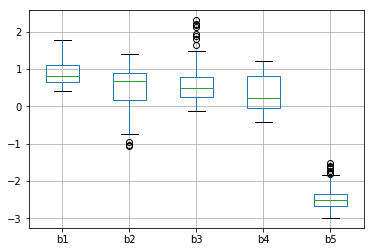

In [8]:
beta_bootstrap.boxplot()

### compute std and T-value

In [9]:
beta_std = np.std(beta_bootstrap, axis=0)
statistics = lm.coef_ / beta_std
(1 - stats.t.cdf(statistics, 200-5-1)) > 0.05

array([False,  True, False,  True,  True])

## exercise 2 

In [29]:
Y = pd.read_csv('y.txt',header= None)
Y.columns = ['Y']
np.mean(Y)

Y    3.946512
dtype: float64

In [73]:
stats.norm.pdf(x = 0)

0.3989422804014327

In [82]:
def Q(theta,theta_star):
    return stats.norm.pdf(x=theta, loc=theta_star,scale=1)

# define p(theta|X)
def p(theta,Y):
    l = (Y-theta)**2
    s = l.sum()
    res = np.exp(-s/2) * theta**2 * np.exp(-2*theta)
    return res

#define alpha
def al(theta_star, theta, Y):
    return (Q(theta,theta_star) * p(theta_star, Y))/(Q(theta_star,theta) * p(theta,Y))

i = 0
y = random.normalvariate(0,1)


ls = [i for i in range(10001)]

while i < 10000:
        x_star = stats.norm.rvs(loc = ls[i], scale = 1, size = 1)
        
        res = random.uniform(0,1)
        
        if res < max(1, float(al(x_star, ls[i], Y))):
        
            ls[i + 1] = float(x_star)
            
        else:
            ls[i + 1] + ls[i]
        
        i = i + 1

In [84]:
np.mean(ls[5000:])

-54.38555677533779

In [39]:
?stats.norm.rvs

## exercise 4 

### generate multinormal using Gibbs 

In [10]:
Sigma = np.array([[1,1,1.5],
                 [1,2,2],
                 [1.5,2,4]])

mu = np.array([1, 3, -2])
B = np.linalg.inv(Sigma)

#X condition on Y,Z
def margin_x(y, z):
    
    mu_x = mu[0] - (1/B[0,0]) * B[0,[1,2]] @ np.array([[y - mu[1]],[z - mu[2]]]) 
    sigma_x = 1/B[0,0]
    
    return float(random.normalvariate(mu_x, sigma_x))

def margin_y(x, z):
    
    mu_y = mu[1] - (1/B[1,1]) * B[1,[0,2]] @ np.array([[x - mu[0]],[z - mu[2]]]) 
    sigma_y = 1/B[1,1]
    
    return float(random.normalvariate(mu_y, sigma_y))

def margin_z(x, y):
    
    mu_z = mu[2] - (1/B[2,2]) * B[2,[0,1]] @ np.array([[x - mu[0]],[y - mu[1]]]) 
    sigma_z = 1/B[2,2]
    
    return float(random.normalvariate(mu_z, sigma_z))

In [11]:
i = 0
x_list = []
y_list = []
z_list = []

y = np.random.randn()
z = np.random.randn()

while i < 100:
    x = margin_x(y,z)
    y = margin_y(x,z)
    z = margin_z(x,y)
    
    x_list.append(x)
    y_list.append(y)
    z_list.append(z)

    i = i + 1

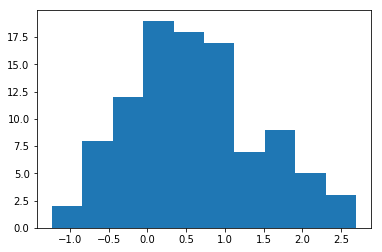

In [12]:
plt.hist(x_list)
plt.show()

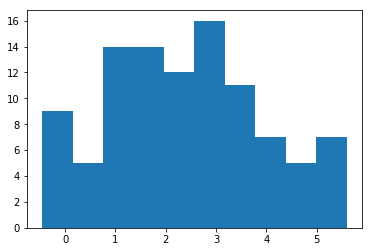

In [13]:
plt.hist(y_list)
plt.show()

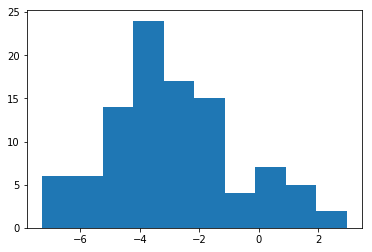

In [14]:
plt.hist(z_list)
plt.show()

### using cholesky to generate x,y,z

In [15]:
A = np.linalg.cholesky(Sigma)

mu = np.array([[1], [3], [-2]])

#generate variable Y and  X
i = 0
X_matrix = DataFrame(columns=['x','y','z'])
while i < 200:
    
    Z = np.random.randn(3,1) 
    X = A @ Z + mu
    X_matrix.loc[i] = [float(i) for i in X]
    i = i + 1

### compare 

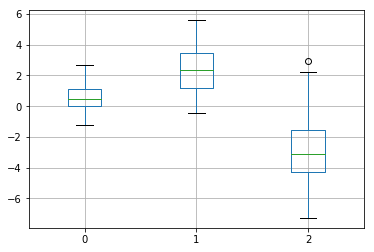

In [16]:
DataFrame([x_list,y_list,z_list]).T.boxplot()

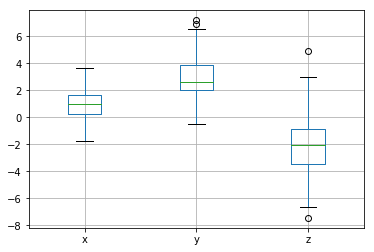

In [17]:
X_matrix.boxplot()

according to the boxplot, the distribution of gibbs and orinigal multinorm are very similar.

because Gbbis satisfy detailed balance condition, and it doesn't need to discard some data.